In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import njit

In [4]:
def Plot_Opinion_Distribution_2d(data1, data2, data_act):
    op1_list = data1
    op2_list = data2

    fig, ax = plt.subplots(1,3, figsize=(12,4))
    ax[0].set_title("Topic 1")
    ax[0].set_xlabel("Opinion")
    ax[0].set_ylabel("# of Opinions on Topic 1")
    ax[0].hist(op1_list, bins=60, density=True)
    ax[1].set_title("Topic 2")
    ax[1].set_xlabel("Opinion")
    ax[1].set_ylabel("# of Opinions on Topic 2")
    ax[1].hist(op2_list, bins=60, density=True)
    ax[2].set_title("Opinion-Space")
    ax[2].set_xlabel("Opinion 1")
    ax[2].set_ylabel("Opinion 2")
    ax[2].scatter(op1_list, op2_list, c=data_act, cmap='cool', marker = '2')
    plt.show()

def Agglomerative_Algorithm(data, thresh, runtime, min_nodes):
    # get number of nodes
    N = len(data[0])
    # Declare needed array
    nodes = np.empty((N,3))

    # Fill node array. Last entry is the number of agglom. nodes, first two
    # are the opinion of the node. Last one is its index
    for i in range(N):
        nodes[i][0] = data[len(data)-2][i]
        nodes[i][1] = data[len(data)-1][i]
        nodes[i][2] = 1

    node_count = N

    final_nodes = []

    # Avoid cases where all nodes are cut off, which results in an empty array
    # of final_nodes which results in an error for the classifier
    while len(final_nodes) == 0:

        # Start simulations
        t = 0
        while t < runtime:
            # Create current index array
            inds = np.arange(0, len(nodes), 1, dtype=int)

            # Prepare arrays that save newly created nodes and the ones that were 
            # deleted in the iteration
            nodes_new = []
            deletes = []

            for i in range(len(nodes)):
                # Skip nodes that were merged
                if (i in inds) == True and len(inds)>1:
                    # Make sure that the loop stops if all nodes were merged.
                    # Loop only continues if atleast 2 nodes are left to be merged
                    if node_count > 1:
                        # Pick random entry of nodes
                        rand = i
                        while rand == i or rand == -1:
                            rand = np.random.choice(inds)
                            rand_node = nodes[rand]

                        # Calculate opinion distance
                        op_dist = np.sqrt( (rand_node[0]-nodes[i][0])**2 + (rand_node[1]-nodes[i][1])**2 )
                        # Implement threshold
                        if op_dist < thresh:

                            # Delete used nodes from indice index
                            count = []
                            for j in range (len(inds)):
                                if inds[j] == i or inds[j] == int(rand):
                                    count.append(j)
                            inds = np.delete(inds, count)

                            deletes.append(i)
                            deletes.append(int(rand))
                                    
                            # Extract numbers of nodes
                            n1 = int(nodes[i][2])
                            n2 = int(rand_node[2])
                            # Calculate and append new opinions and number of agglom. nodes
                            avr1 = ( n1*nodes[i][0] + n2*rand_node[0]) / (n1+n2)
                            avr2 = ( n1*nodes[i][1] + n2*rand_node[1]) / (n1+n2)
                            n = n1+n2
                            nodes_new.append( [avr1, avr2, n] )
                            node_count -= 1
                    else:
                        # Stop loop if not enough nodes are left to be merged.
                        break

            # Delete old nodes
            nodes = np.delete( nodes, deletes, axis=0 )

            # Append new nodes to nodes array
            
            if nodes_new != []:
                nodes = np.append(nodes, nodes_new, axis=0)
        
            t += 1

        # Only return nodes with #nodes >= min_nodes
        final_nodes = []
        for i in range (len(nodes)):
            if nodes[i][2] >= min_nodes:
                final_nodes.append( nodes[i] )
        final_nodes = np.array( final_nodes )
    
    # return last list only containing opinion and number of nodes
    return final_nodes

#@njit
def Count(data, counts, num_aggs, i, j, k):
    for l in range (num_aggs):
        print(f"i: {i};\tj: {j};\tk: {k}\tl: {l}")
        # Perform algorithm until 1 <= #nodes <= 5
        num_nodes = 6
        while num_nodes > 5 or num_nodes == 0:
            last_nodes = Agglomerative_Algorithm(data, 2.5, 100, 250)
            num_nodes = len( last_nodes )
        # Classify case
        if num_nodes == 1:
            counts[0] += 1
        if num_nodes == 2:
            counts[2] += 1
        if num_nodes == 4:
            counts[1] += 1
        if num_nodes == 5:
            counts[1] += 1
        # Special case of 3 nodes, since often problems at the phaseshift between 
        # Consensus and ideology happen
        if num_nodes == 3:
            # Sort nodes from smallest to biggest. If the biggest is bigger than 
            # the first and second nodes the big one usually sits in the middle,
            # which generally happens at consensus
            last_nodes = last_nodes[np.argsort( last_nodes[:,2] )]
            if last_nodes[0][2] + last_nodes[1][2] < last_nodes[2][2]:
                counts[0] += 1
            else:
                counts[2] += 1


def Agglomerative_Classifier(frac, sims, num_aggs):

    if num_aggs % 2 == 0:
        print("ERROR! Uneven number of agglomerative runs is needed.\n")
        return 0

    alphas = np.arange(0.0, 4.1, 0.1)
    cosds = np.arange(0.0, 1.1, 0.1)

    saves = np.zeros((len(alphas), len(cosds)))

    for i in range(len(alphas)):
        for j in range(len(cosds)):
            
            # Count wether algorithm says dataset is consensus, polarization or ideology
            # First entry is cons-counter, 2nd polarization and 3rd ideology
            counts = np.zeros(3, dtype=int)
            for k in range(sims):

                # Load data
                df = pd.read_csv(f'D:\Daten mit Änderungen\Physik\Bachelorarbeit\Generated_Data\Bound\Phase\\a{alphas[i]:.1f}_b5.0_cosd{cosds[j]:.1f}_frac_{frac:.1f}_{k+1}.csv', header = None)
                data = df.to_numpy()
                # Number of nodes
                N = len(data[0])
                # Neglect nodes that stay around zero.
                sorts = np.argsort( data[0] )
                # Transpose to access nodes
                sorted = data.T[sorts]
                Num = int(N * (1-frac))
                # Transpose back
                data = sorted[:Num].T

                Count(data, counts, num_aggs, i, j, k)
                
            saves[i][j] = np.argmax(counts)

    pd.DataFrame(saves).to_csv(f"D:\Daten mit Änderungen\Physik\Bachelorarbeit\Generated_Data\Bound\Heatmap_frac{frac}.csv", index = False, header = False)
    return saves
                    

            




In [ ]:
res = Agglomerative_Classifier(0.0, 1, 9)

[[  1.68470569  -1.75167176 480.        ]
 [ -2.54240072   2.54422926 415.        ]
 [  2.68881612   2.65696768 389.        ]
 [ -2.82425458  -2.85154105 438.        ]]
4


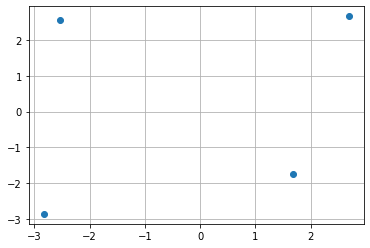

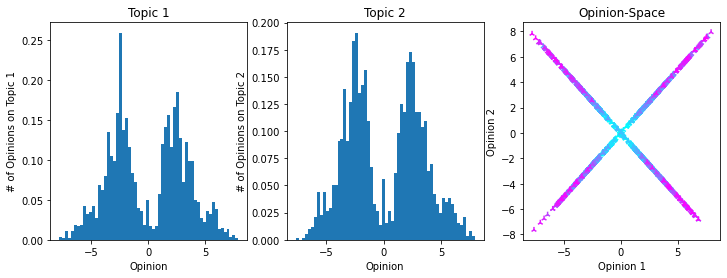

In [5]:
# Trying out for single datasets


# Load dataset
df = pd.read_csv(f'D:\Daten mit Änderungen\Physik\Bachelorarbeit\Generated_Data\Bound\Phase\\a2.0_b5.0_cosd0.0_frac_0.2_1.csv', header = None)
data = df.to_numpy()

N = len(data[0])

# Exclude bounded nodes
frac = 0.2
# Neglect nodes that stay around zero.
sorts = np.argsort( data[0] )
#print(sorts)
# Transpose to access nodes
sorted = data.T[sorts]
Num = int(N * (1-frac))
# Transpose back
data = sorted[:Num].T

results = Agglomerative_Algorithm(data, 2.5, 100, 250)

print(results)
print(len(results))

plt.figure()
plt.scatter( results[:,0], results[:,1] )
plt.grid()
Plot_Opinion_Distribution_2d(data[len(data)-2], data[len(data)-1], data[0])

# Problems with classifying transmission from consens to ideology:
# Often one or two more nodes beside the big one in the middle emerge.
# Some cases can still be correctly classified when comparing the size and
# using for example a size-difference of 500 to the node in the middle to
# still classify the whole thing as consensus. Still, one or two paramter-
# pairs will be missclassified.